In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import signal
from scipy.misc import imread, imsave, face
from scipy.fftpack import fft2, ifft2
import matplotlib.pyplot as plt

from os import listdir
from parse import *
import os
import re

In [2]:
def upsample(img, n):
    # размеры в n раз больше
    new_shape = tuple(map(lambda x: x * n, img.shape))
    
    new_img = np.empty(new_shape)
    for i in xrange(img.shape[0]):
        for j in xrange(img.shape[1]):
            new_img[i*n:(i+1)*n, j*n:(j+1)*n] = np.full((n, n), img[i, j])
    return new_img

In [3]:
def deconv2(c, b):
    Nout = c.shape[0] - b.shape[0] + 1
    Mout = c.shape[1] - b.shape[1] + 1
    b = np.pad(b, [(0, c.shape[0] - b.shape[0]), (0, c.shape[1] - b.shape[1])], "constant", constant_values=0)
    
    a = ifft2(fft2(c) / fft2(b))
    a = np.real(a[:Nout, :Mout])
    return a

In [4]:
def wiener_deconv2(c, b, snr):
    Nout = c.shape[0] - b.shape[0] + 1
    Mout = c.shape[1] - b.shape[1] + 1
    b = np.pad(b, [(0, Nout-1), (0, Mout-1)], "constant", constant_values=0)
    
    Fc = fft2(c)
    Fb = fft2(b)
    
    G = (Fb * np.conj(Fb)) / (Fb * np.conj(Fb) + 1.0 / snr) / Fb
    a = ifft2(G * Fc)
    a = np.real(a[:Nout, :Mout])
    a[abs(a) < 1e-12] = 0.0
    return a

In [5]:
def show_pics(pics, titles):
    _, axis = plt.subplots(nrows=1, ncols=len(pics), sharex=True, sharey=True, figsize=(14,6))
    for i in xrange(len(pics)):
        axis[i].imshow(pics[i], cmap='Greys_r')
#         axis[i].axis('off')
        axis[i].set_title(titles[i])
    plt.show()

Когда мы строим свернутую картинку из сэмплов, мы не знаем размер исходного изображения, поэтому полагаем, что размеры исходного изображения = размеры сэмпла * размер шаблона. То есть размер изображения на выходе свертки должен быть равен размеру изображения на выходе нашего построения из сэмплов.

Обозначим за $k$ размер шаблона, а за $h$ один из размеров изображения и проследим как он меняется.
При свертке:
$$ h_c = h + k - 1 $$
При нашем построении из сэмплов:
$$ H = h + 2(k-1) - [\text{дополнение нулями с двух сторон}] $$
$$ h_m = [\frac{H}{k}] - [\text{количество укладываемых шаблонов}] $$
$$ h_s = h_m * k - [\text{размер на выходе построения}]$$

$$ h_s = h_c $$
То есть
$$ \left[\frac{h + 2(k-1)}{k}\right]k = h + k - 1 $$
$$ \left[\frac{h - 2}{k}\right]k + 2k = h + k - 1 $$
$$ \left[\frac{h - 2}{k}\right] = \frac{h - 1}{k} - 1 $$

Получаем, что $h-1$ нацело делится на $k$ и, следовательно $\left[\frac{h - 2}{k}\right]$ ровно на 1 меньше, чем $\frac{h - 1}{k}$.

Все аналогично для второго размера.

In [6]:
def generate_sample_images(img, psf):
    k = psf.shape[0]; # assume psf as square template
    
    # pad image with zeros
    padded = np.pad(img, [(k-1, k-1), (k-1, k-1)], "constant", constant_values=0)
    
    sample_rows, sample_cols = padded.shape[0] / k, padded.shape[1] / k
    samples = np.empty((k, k, sample_rows, sample_cols))  
    
    # anchor_y, anchor_x - координаты в img, с которых мы начинаем прикладывать левый верхний край шаблона
    for anchor_y in xrange(k):
        for anchor_x in xrange(k):
            tmp = np.zeros((sample_rows, sample_cols))
            
            # y, x - coordinates where the template (upper left corner) is attached
            for y in xrange(anchor_y, padded.shape[0] - (k-1), k):
                for x in xrange(anchor_x, padded.shape[1] - (k-1), k):
                    i = (y - anchor_y) / k
                    j = (x - anchor_x) / k
                    tmp[i, j] = np.sum(padded[y:y+k, x:x+k] * psf)
            samples[anchor_y, anchor_x] = tmp
    return samples

In [7]:
def conv_from_samples(samples, to_shape=None):
    k, _, sample_rows, sample_cols = samples.shape # assume psf as square template
    if to_shape:
        sampled = np.empty(to_shape)
    else:
        sampled = np.empty((k*sample_rows, k*sample_cols))
                           
    for anchor_y in xrange(k):
        for anchor_x in xrange(k): 
            for y in xrange(anchor_y, sampled.shape[0], k):
                for x in xrange(anchor_x, sampled.shape[1], k):
                    i = (y - anchor_y) / k
                    j = (x - anchor_x) / k
                    sampled[y, x] = samples[anchor_y, anchor_x, i, j]
    return sampled

In [8]:
def save_24bit(name, img_f32):
    img = Image.fromarray(img_f32)
    img = img.convert(mode="RGB")
    img.save(name)
    
def save_samples(samples, path, base_name, extension=".png"):
    for ay in xrange(samples.shape[0]):
        for ax in xrange(samples.shape[1]):
            name = os.path.join(path, base_name + ("_ay=%d_ax=%d" % (ay, ax)) + extension) 
            save_24bit(name, samples[ay, ax])

In [9]:
def read_samples(path, base_name, extension=".png"):
    pattern = re.compile(base_name + "_ay=[0-9]+_ax=[0-9]+\\" + extension)
    samples_paths = [entry for entry in listdir(path) if pattern.match(entry)]
    k = int(len(samples_paths) ** 0.5) # assume the correct number of sample in the folder
    sample_shape = imread(samples_paths[0], flatten=True).shape
    samples = np.empty((k, k) + sample_shape)
    for sample_name in samples_paths:
        r = parse(base_name + "_ay={:d}_ax={:d}" + extension, sample_name)
        (ay, ax) = r.fixed
        samples[ay, ax] = imread(os.path.join(path, sample_name), flatten=True)
    return samples

(768L, 1024L)


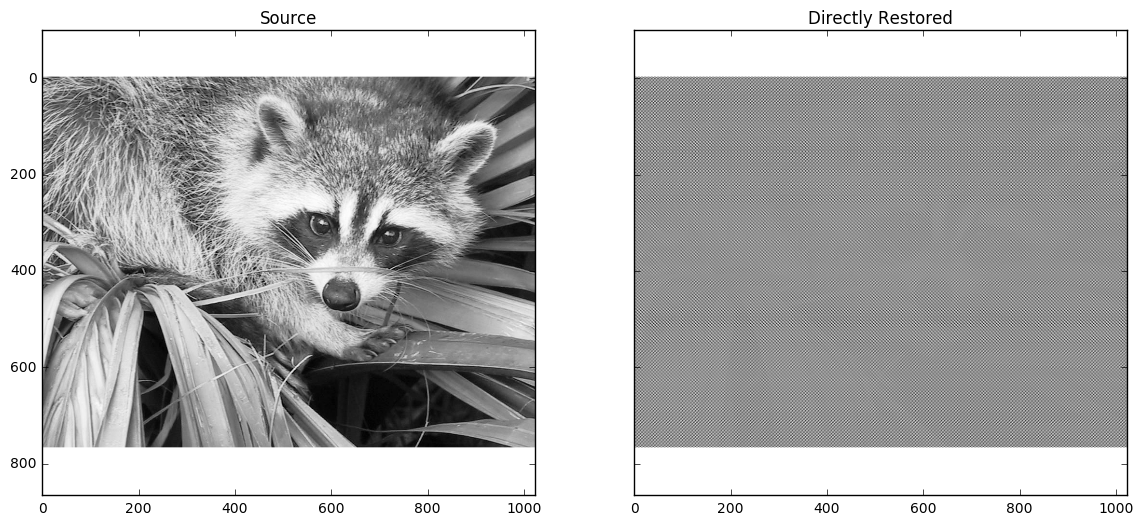

In [238]:
k = 3
psf = np.ones((k, k)) / k ** 2

src = face(gray=True); # imread("../images/peka.png", flatten=True)

# mod = src.shape[0] % k, src.shape[1] % k
# print mod
# if mod[0] == 0:
#     src = src[:-k+1, :]
# elif mod[0] != 1:
#     src = src[:-mod[0]+1, :]
    
# if mod[1] == 0:
#     src = src[:, :-k+1]
# elif mod[1] != 1:
#     src = src[:, :-(mod[1]-1)]
    
print src.shape
direct_conv = signal.convolve2d(src, psf)
direct_rest = deconv2(direct_conv, psf)
show_pics([src, direct_rest], ["Source", "Directly Restored"])

In [237]:
help(np.factor)

AttributeError: 'module' object has no attribute 'factor'